# SVM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from models.svm import SVM
from utils.datasets import blobs_classification_dataset, radial_classification_dataset
from utils.visualization import plot_decision_boundary

In [2]:
%matplotlib inline

# Turn interactive plotting off
plt.ioff()

In [28]:
(x_train, y_train), (x_test, y_test) = blobs_classification_dataset(features=2, classes=2)

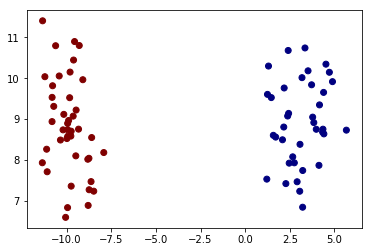

In [29]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In [37]:
model = SVM(C=10)

In [38]:
y_train.shape

(80,)

In [39]:
loss = model.fit(x_train, y_train, iterations=100000, learning_rate=1e-3)

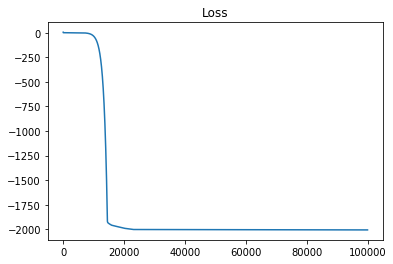

In [40]:
plt.plot(loss[1:])
plt.title('Loss')
plt.show();

In [41]:
y_hat = model.predict(x_test)

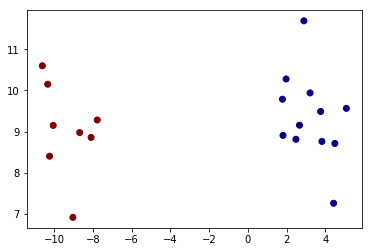

In [42]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_hat, cmap='jet')
plt.show()

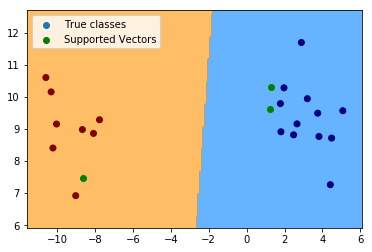

In [43]:
ax = plot_decision_boundary(model.predict,
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
# Plot test data
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet', label='True classes')

# Plot supported vectors
ax.scatter(model.supported_vectors[:, 0], model.supported_vectors[:, 1], color='green', label='Supported Vectors')
ax.legend()
ax.set_xlim(x_test[:, 0].min()-1, x_test[:, 0].max()+1)
ax.set_ylim(x_test[:, 1].min()-1, x_test[:, 1].max()+1)
plt.show()

# Non-linearly separable dataset

In [44]:
(x_train, y_train), (x_test, y_test) = radial_classification_dataset()

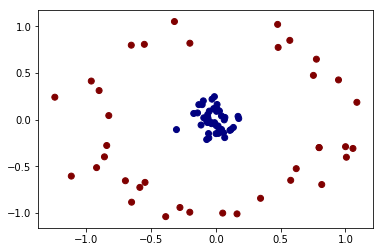

In [45]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In [46]:
loss = model.fit(x_train, y_train, iterations=10000)

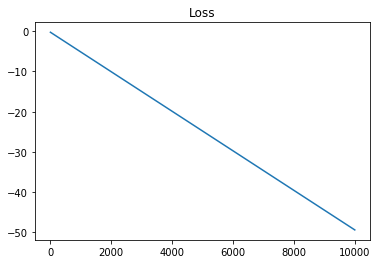

In [47]:
plt.plot(loss[1:])
plt.title('Loss')
plt.show();

In [48]:
y_hat = model.predict(x_test)

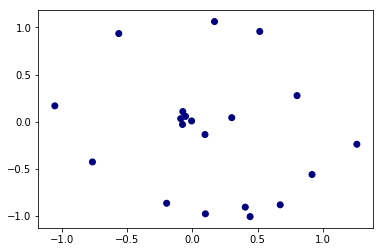

In [49]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_hat, cmap='jet')
plt.show()

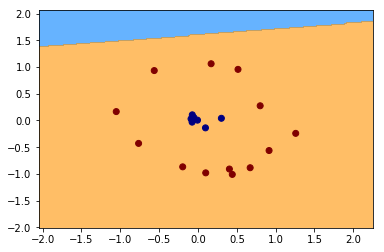

In [50]:
ax = plot_decision_boundary(model.predict,
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet')
plt.show()

# Kernel trick

In [63]:
quadratic_model = SVM(kernel='quadratic', C=1000)

In [64]:
loss = quadratic_model.fit(x_train, y_train, iterations=100000, learning_rate=1e-3)

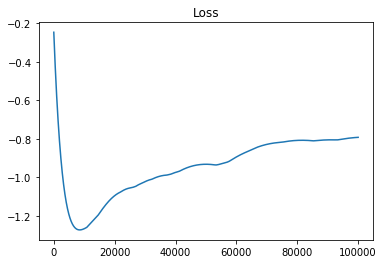

In [65]:
plt.plot(loss[1:])
plt.title('Loss')
plt.show();

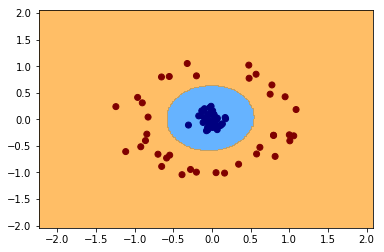

In [66]:
ax = plot_decision_boundary(quadratic_model.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1])
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()